# Autoencoder

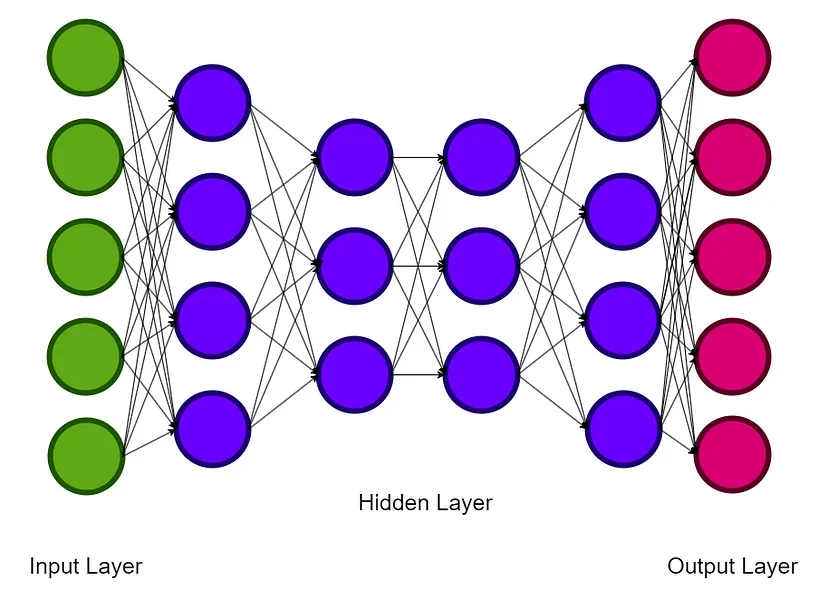

- Input Shape: 28, 28, 1
- Latent Shape: 16, 16, 1
- Output Shape: 28, 28, 1

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
train_data = pd.read_csv('data/mnist_train.csv')
test_data = pd.read_csv('data/mnist_test.csv')

train_data = train_data.drop('label', axis=1)
test_data = test_data.drop('label', axis=1)

train_data = train_data.values.reshape(-1, 784)
test_data = test_data.values.reshape(-1, 784)

# plt.imshow(train_data[1].values.reshape(28, 28), cmap='gray')

In [23]:
train_data = train_data / 255.0
test_data = test_data / 255.0

In [24]:
train_data.shape

(60000, 784)

In [25]:
def relu(x):
    return np.maximum(0.01 * x, x) # Leaky ReLU

def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=0)

def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def bce_loss(y_true, y_pred):
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # Compute BCE loss
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# def init_params(input_size, hidden_size, output_size):
#     W1 = np.random.randn(hidden_size, input_size) * 0.01
#     b1 = np.zeros((hidden_size, 1))
#     W2 = np.random.randn(output_size, hidden_size) * 0.01
#     b2 = np.zeros((output_size, 1))
#     return W1, b1, W2, b2

def init_params(input_size, output_size):
    W1 = np.random.randn(output_size, input_size) * np.sqrt(2. / input_size)
    b1 = np.zeros((output_size, 1))
    return W1, b1

def dense(x, w, b):
    # if len(x.shape) > 1:
    #     b = np.repeat(b, x.shape[0], axis=1).T
    return np.dot(x, w) + b

def calculate_accuracy(y_true, y_pred, threshold=0.1):
    diff = np.abs(y_true - y_pred)
    correct_features = (diff < threshold).astype(int)
    sample_accuracy = np.mean(correct_features, axis=1)
    overall_accuracy = np.mean(sample_accuracy) * 100
    return overall_accuracy



In [26]:
class AdamOptimizer:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_w = 0
        self.v_w = 0
        self.m_b = 0
        self.v_b = 0
        self.t = 0
        
    def update(self, param, grad, m, v):
        self.t += 1
        m = self.beta1 * m + (1 - self.beta1) * grad
        v = self.beta2 * v + (1 - self.beta2) * (grad ** 2)
        
        m_hat = m / (1 - self.beta1 ** self.t)
        v_hat = v / (1 - self.beta2 ** self.t)
        
        param -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return param, m, v

In [27]:
class Encoder:
    def __init__(self, input_size, hidden_size, optimizer):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.optimizer = optimizer
        self.W1, self.b1 = init_params(input_size, hidden_size)
        self.m_w1 = self.v_w1 = np.zeros_like(self.W1)
        self.m_b1 = self.v_b1 = np.zeros_like(self.b1)

    def forward(self, x):
        self.x = x
        self.z1 = dense(x, self.W1.T, self.b1.T)
        self.a1 = relu(self.z1)
        return self.a1
    
    def backward(self, y):
        m = y.shape[0]
        dz1_raw = np.dot(self.W1, self.x.T)
        self.dz1 = dz1_raw.T * (self.a1 > 0)
        self.dW1 = np.dot(self.dz1.T, self.x) / m
        self.db1 = np.sum(self.dz1, axis=0, keepdims=True).T / m

    def update(self):
        self.W1, self.m_w1, self.v_w1 = self.optimizer.update(self.W1, self.dW1, self.m_w1, self.v_w1)
        self.b1, self.m_b1, self.v_b1 = self.optimizer.update(self.b1, self.db1, self.m_b1, self.v_b1)

In [28]:
class Decoder:
    def __init__(self, hidden_size, output_size, optimizer):
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.optimizer = optimizer
        self.W2, self.b2 = init_params(hidden_size, output_size)
        self.m_w2 = self.v_w2 = np.zeros_like(self.W2)
        self.m_b2 = self.v_b2 = np.zeros_like(self.b2)

    def forward(self, x):
        self.x = x
        self.z2 = dense(x, self.W2.T, self.b2.T)
        self.a2 = sigmoid(self.z2)
        return self.a2
    
    def backward(self, y):
        m = y.shape[0]
        self.dz2 = self.a2 - y
        self.dW2 = np.dot(self.dz2.T, self.x) / m
        self.db2 = np.sum(self.dz2, axis=0, keepdims=True).T / m

    def update(self):
        self.W2, self.m_w2, self.v_w2 = self.optimizer.update(self.W2, self.dW2, self.m_w2, self.v_w2)
        self.b2, self.m_b2, self.v_b2 = self.optimizer.update(self.b2, self.db2, self.m_b2, self.v_b2)

------------------------------------------------------------
Layer (Type)         Output Shape         Param #   
Encoder (Dense):          (256,)       200960    
Decoder (Dense):          (784,)      201488    
Total Parameters: 402448
Trainable Parameters: 402448
Non-trainable Parameters: 0
------------------------------------------------------------
-----------------------------------------------
Epoch 1/300 - Loss: 0.3840, Accuracy: 21.52900297619048%
-----------------------------------------------
Epoch 2/300 - Loss: 0.2798, Accuracy: 56.69454931972789%
-----------------------------------------------
Epoch 3/300 - Loss: 0.2642, Accuracy: 59.54459396258503%
-----------------------------------------------
Epoch 4/300 - Loss: 0.2551, Accuracy: 59.86257653061225%
-----------------------------------------------
Epoch 5/300 - Loss: 0.2483, Accuracy: 60.191162840136045%
-----------------------------------------------
Epoch 6/300 - Loss: 0.2427, Accuracy: 60.7926955782313%
--------------

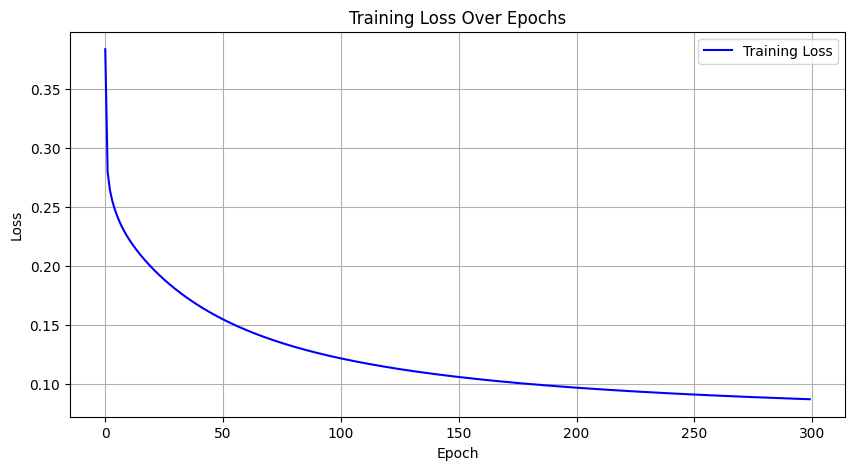

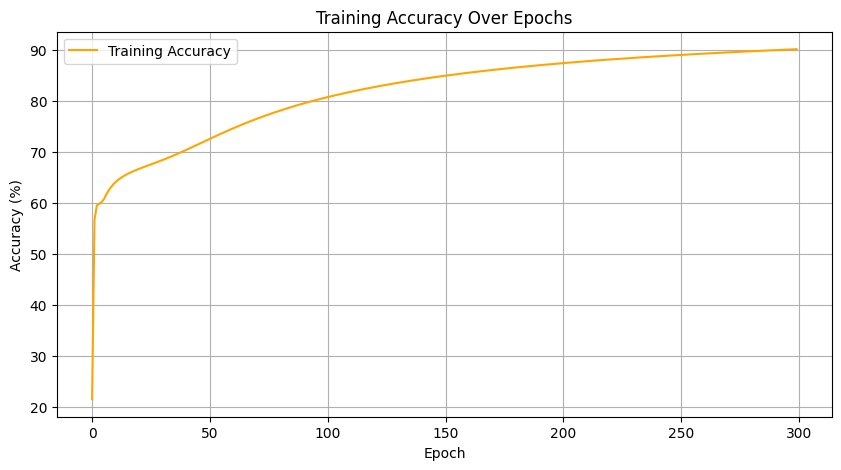

In [29]:
class Autoencoder:
    def __init__(self, input_size, hidden_size, optimizer):
        self.encoder = Encoder(input_size, hidden_size, optimizer)
        self.decoder = Decoder(hidden_size, input_size, optimizer)
        self.optimizer = optimizer
        self.loss_history = []
        self.total_params = self.calculate_total_params()
        
    def calculate_total_params(self):
        encoder_params = np.prod(self.encoder.W1.shape) + np.prod(self.encoder.b1.shape)
        decoder_params = np.prod(self.decoder.W2.shape) + np.prod(self.decoder.b2.shape)
        return encoder_params + decoder_params
    
    def summary(self):
        # Header
        print("------------------------------------------------------------")
        print(f"{'Layer (Type)':<20} {'Output Shape':<20} {'Param #':<10}")
        print("============================================================")
        
        # Encoder details
        encoder_params = np.prod(self.encoder.W1.shape) + np.prod(self.encoder.b1.shape)
        print(f"Encoder (Dense):{'':<9} ({self.encoder.hidden_size},)       {encoder_params:<10}")
        
        # Decoder details
        decoder_params = np.prod(self.decoder.W2.shape) + np.prod(self.decoder.b2.shape)
        print(f"Decoder (Dense):{'':<9} ({self.decoder.output_size},)      {decoder_params:<10}")
        
        # Footer
        print("============================================================")
        print(f"Total Parameters: {self.total_params}")
        print(f"Trainable Parameters: {self.total_params}")
        print(f"Non-trainable Parameters: 0")
        print("------------------------------------------------------------")
        
    def forward(self, x):
        self.encoded = self.encoder.forward(x)
        self.decoded = self.decoder.forward(self.encoded)
        return self.decoded
    
    def backward(self, y):
        self.decoder.backward(y)
        self.decoder.update()
        self.encoder.backward(y)
        self.encoder.update()
        
    def train(self, x, y, epochs, batch_size, threshold=0.1):
        m = x.shape[0]
        self.accuracy_history = []

        for epoch in range(epochs):
            epoch_loss = 0
            all_predictions = []
            all_true_values = []

            for i in range(0, m, batch_size):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                
                self.forward(x_batch)
                self.backward(y_batch)

                batch_loss = bce_loss(y_batch, self.decoded)
                epoch_loss += batch_loss

                all_predictions.append(self.decoded)
                all_true_values.append(y_batch)

            avg_epoch_loss = epoch_loss / (m // batch_size)
            self.loss_history.append(avg_epoch_loss)

            all_predictions = np.vstack(all_predictions)
            all_true_values = np.vstack(all_true_values)

            accuracy = calculate_accuracy(all_true_values, all_predictions, threshold)
            self.accuracy_history.append(accuracy)

            print("-----------------------------------------------")
            print(f'Epoch {epoch + 1}/{epochs} - Loss: {avg_epoch_loss:.4f}, Accuracy: {accuracy}%')

        self.plot_metrics()

            
    def predict(self, x):
        return self.forward(x)
    
    def evaluate(self, x, y):
        predictions = self.predict(x)
        loss = bce_loss(y, predictions)
        return loss
    
    def plot_metrics(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.loss_history, label="Training Loss", color='blue')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.legend()
        plt.grid()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(self.accuracy_history, label="Training Accuracy", color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Training Accuracy Over Epochs')
        plt.legend()
        plt.grid()
        plt.show()




learning_rate = 0.001
batch_size = 64
epochs = 300 

optimizer = AdamOptimizer(lr=learning_rate)            
autoencoder = Autoencoder(784, 256, optimizer)
autoencoder.summary()
autoencoder.train(train_data, train_data, epochs, batch_size)

Test Loss: 0.08591454945254413


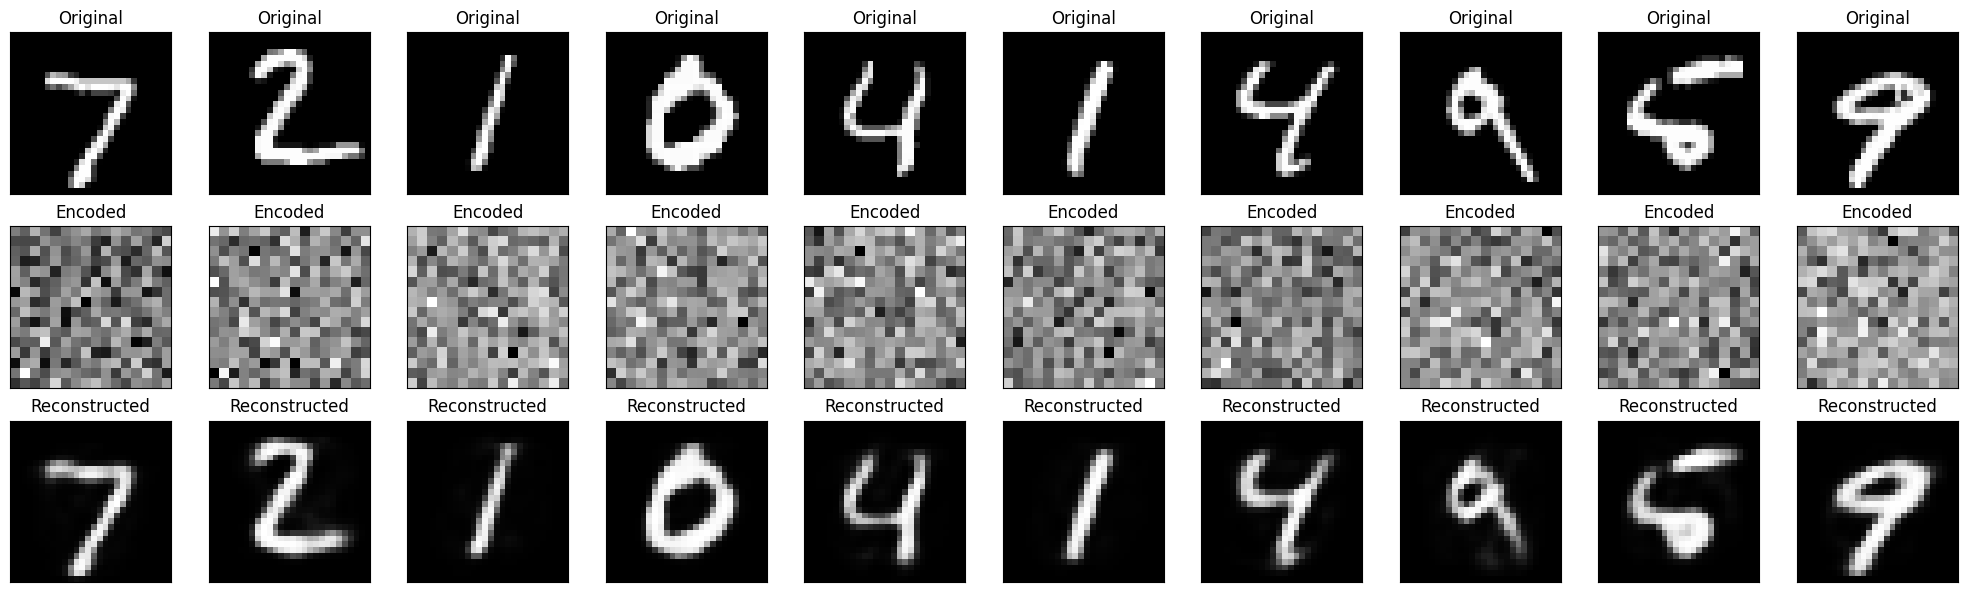

In [36]:
# Testing the model
test_loss = autoencoder.evaluate(test_data, test_data)
print(f'Test Loss: {test_loss}')

n = 10 
plt.figure(figsize=(20, 6))

for i in range(n):
    # Original Image
    ax = plt.subplot(3, n, i + 1)
    plt.title("Original")
    plt.imshow(test_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Encoded Image
    encoded_data = autoencoder.encoder.forward(test_data)
    ax = plt.subplot(3, n, i + 1 + n) 
    plt.title("Encoded")
    plt.imshow(encoded_data[i].reshape(16, 16))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed Image
    reconstructed_data = autoencoder.predict(test_data)
    ax = plt.subplot(3, n, i + 1 + 2 * n) 
    plt.title("Reconstructed")
    plt.imshow(reconstructed_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()
